**PREPARACIÓN DEL NOTEBOOK**

In [258]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
#!pip install kneed
from kneed import KneeLocator

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FactorAnalysis

#!pip install factor_analyzer
from factor_analyzer import FactorAnalyzer

## **EDA**

In [259]:
# Lectura de datos limpios
df = pd.read_csv("https://raw.githubusercontent.com/JavierBurgos-web/PROYECTO_ANALITICA_2da_entrega/main/dataset_limpio.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7711 entries, 0 to 7710
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   overall        7711 non-null   int64  
 1   age            7711 non-null   int64  
 2   height_cm      7711 non-null   int64  
 3   weight_kg      7711 non-null   int64  
 4   club_position  7711 non-null   int64  
 5   pace           7711 non-null   float64
 6   shooting       7711 non-null   float64
 7   passing        7711 non-null   float64
 8   dribbling      7711 non-null   float64
 9   defending      7711 non-null   float64
 10  physic         7711 non-null   float64
 11  defending1     7711 non-null   float64
 12  attacking1     7711 non-null   float64
 13  skills1        7711 non-null   float64
 14  mentality1     7711 non-null   float64
 15  movement1      7711 non-null   float64
 16  power          7711 non-null   float64
dtypes: float64(12), int64(5)
memory usage: 1.0 MB


C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

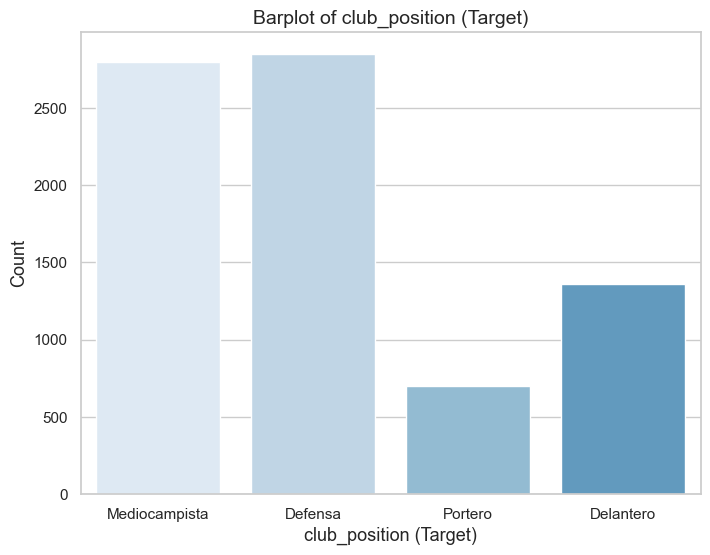

In [260]:
# Estilo de las gráficas
sns.set_theme(style='whitegrid', palette='Blues')

# Variable satisfacción
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='club_position', data=df)
plt.title('Barplot of club_position (Target)', fontsize=14)
plt.xlabel('club_position (Target)', fontsize=13)
plt.ylabel('Count', fontsize=13)

# Cambiamos las etiquetas del eje x
ax.set_xticks(range(4))
ax.set_xticklabels([
    'Mediocampista',
    'Defensa',
    'Portero',
    'Delantero'
])

plt.show()

In [261]:
categories = [0, 1, 2, 3]  # Lista de categorías que deseas analizar
categories_labels = ['Mediocampista', 'Defensa', 'Portero', 'Delantero']

category_dict = dict(zip(categories, categories_labels))  # Diccionario de correspondencia

for category in categories:
    
    mean_value = df[df['club_position'] == category].drop('club_position', axis=1).mean().mean()
    
    mean_value_rounded = round(mean_value, 3)  # Redondear a tres decimales
    category_label = category_dict[category]  # Obtener la etiqueta correspondiente
    print(f"Media para la categoría {category_label}: {mean_value_rounded}")


Media para la categoría Mediocampista: 68.443
Media para la categoría Defensa: 66.029
Media para la categoría Portero: 56.326
Media para la categoría Delantero: 66.381


La clase que mejor puntuación tiene es la de Mediocampista segida por la de Delantero, esto es evidente en los partidos puesto que son las dos posiciones que exigen mayores destrezas.

- **No debe haber mucha diferencia entre las medias** Se debería a datos atipicos

In [262]:
# Puntucación de cada variable respecto a cada clase
df.groupby('club_position')[df.columns.drop('club_position')].mean()

,overall,age,height_cm,weight_kg,pace,shooting,passing,dribbling,defending,physic,defending1,attacking1,skills1,mentality1,movement1,power
club_position,,,,,,,,,,,,,,,,
0,69.114367,26.341315,178.291994,72.523946,69.296998,60.135096,65.272695,68.615797,55.073981,66.363117,54.530260,59.120586,53.491780,61.265070,69.698499,65.957112
1,68.228421,26.789474,182.805965,76.617895,65.916140,42.521404,55.467719,58.870526,65.949474,71.035088,66.307485,50.662877,43.717427,55.687368,63.884281,62.006105
2,69.613409,28.460770,188.947218,82.727532,69.000000,54.000000,58.000000,64.000000,56.000000,66.000000,14.734189,16.698431,15.934379,27.814313,46.085877,43.197432
3,69.267988,26.756241,181.280470,75.675477,72.884728,67.429515,59.380323,68.566079,34.578561,66.582966,30.815957,62.461821,50.450685,57.898678,70.142731,67.923789


## **PRE PROCESAMIENTO DE DATOS**

In [263]:
df.shape

(7711, 17)

#### **NOTA:** Dependiendo de como de el resultado final del algoritmo, se puede descartar las clases en 'club_position' que se concidere de menos valor 

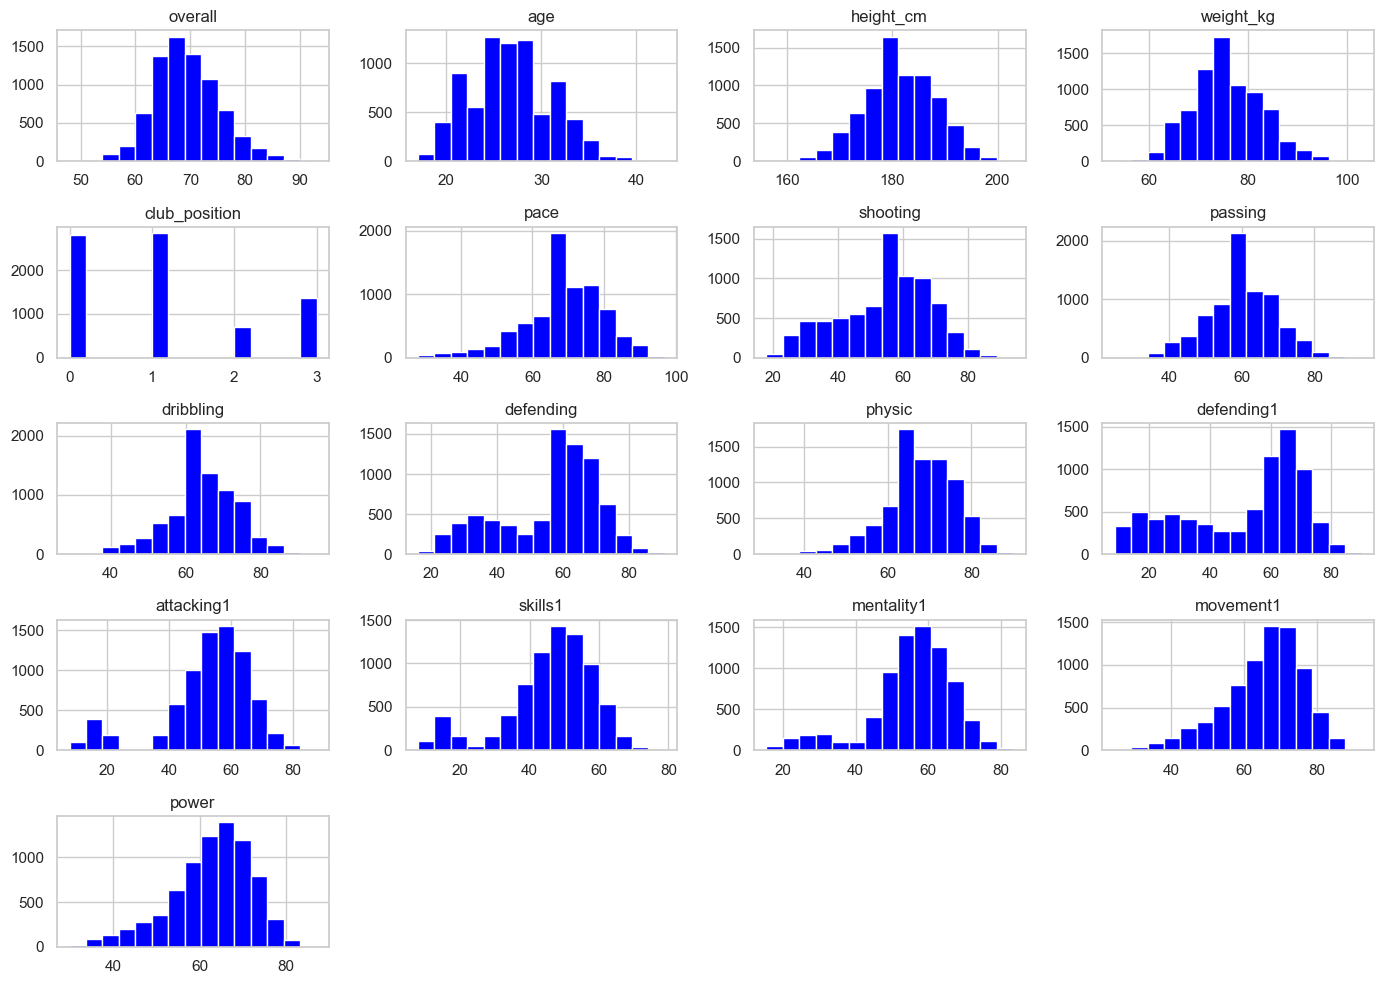

In [264]:
df.hist(figsize=(14, 10), bins=15, color='blue')
plt.tight_layout()
plt.show()

**TRATAMIENTO DE ATIPICOS**

C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

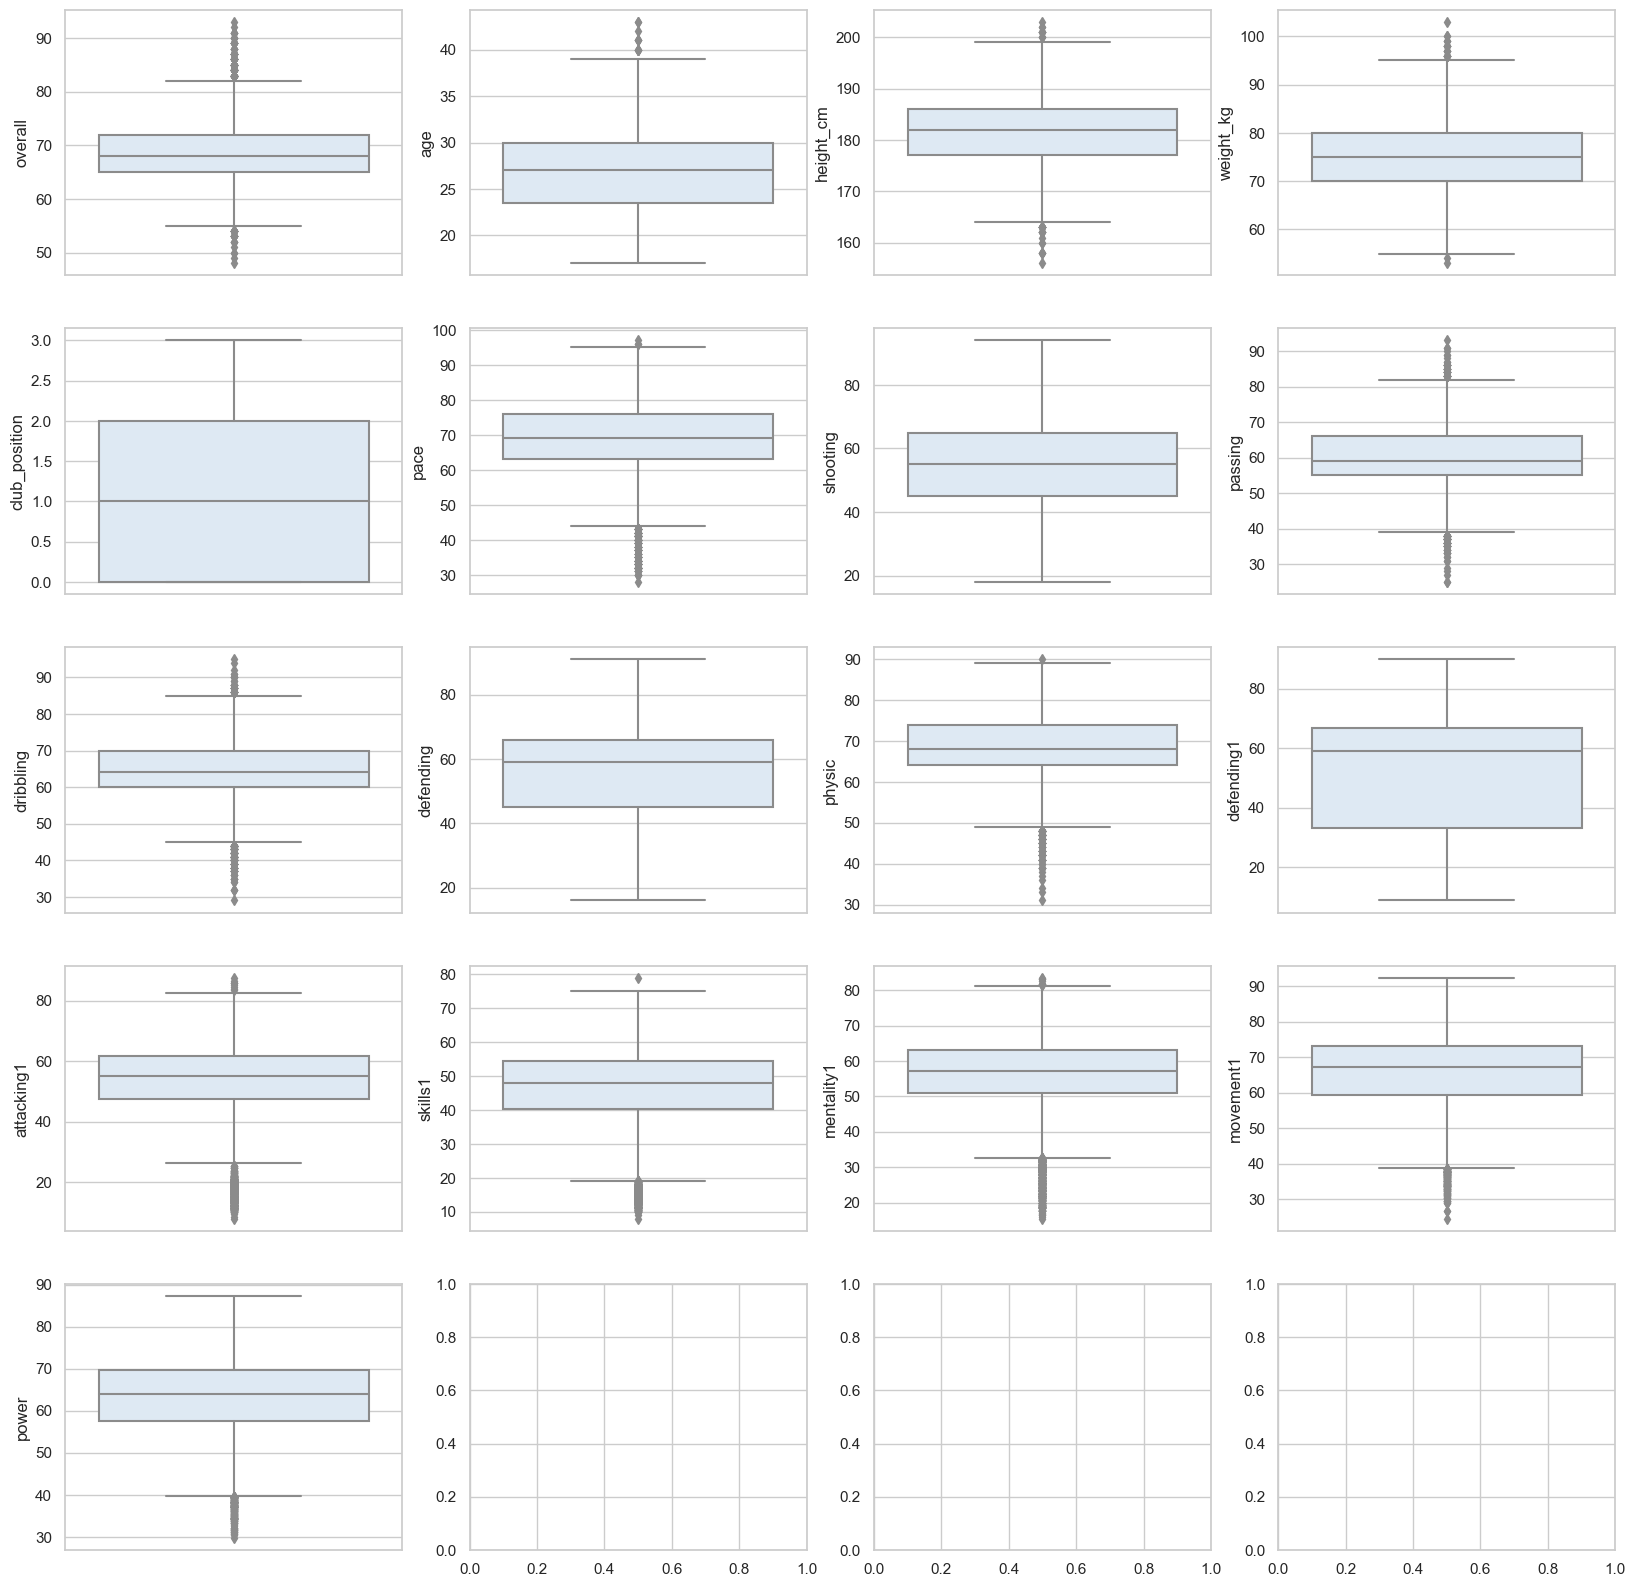

In [265]:
# Tratamiento de valores atípicos
df = df.copy()

# Sentar las bases de un "mosaico boxplot de 6x4 (para cubrir 22 variables)":
box_locs=pd.DataFrame(
{"vert":sorted(list(range(0,6))*4),
 "horiz":list(range(0,4))*6}
)

fig,axs=plt.subplots(ncols=4,nrows=5,figsize=(20,20))

for idx,i in enumerate(df.columns):
    sns.boxplot(y=df[i],ax=axs[box_locs.iloc[idx,0]][box_locs.iloc[idx,1]])

In [266]:
df.shape

(7711, 17)

In [267]:
## Basado en las observaciones de los atipicos realizmos un margen de limites para concervar los datos que esten mas cerca a los limites.
# Take indices of all the outliers:
outs_idx = [
            df[df['overall'] > 83]['overall'].index.astype('int'),
            df[df['overall'] < 38]['overall'].index.astype('int'),
            df[df['age'] > 39]['age'].index.astype('int'),
            df[df['height_cm'] > 199]['height_cm'].index.astype('int'),
            df[df['height_cm'] < 163]['height_cm'].index.astype('int'),
            df[df['weight_kg'] > 95]['weight_kg'].index.astype('int'),
            df[df['weight_kg'] < 53]['weight_kg'].index.astype('int'),
            df[df['pace'] > 96]['pace'].index.astype('int'),
            df[df['pace'] < 43]['pace'].index.astype('int'),
            df[df['passing'] > 82]['passing'].index.astype('int'),
            df[df['passing'] < 39]['passing'].index.astype('int'),
            df[df['dribbling'] > 85]['dribbling'].index.astype('int'),
            df[df['dribbling'] < 45]['dribbling'].index.astype('int'),
            df[df['physic'] > 89]['physic'].index.astype('int'),
            df[df['physic'] < 49]['physic'].index.astype('int'),
            df[df['attacking1'] > 83]['attacking1'].index.astype('int'),
            df[df['attacking1'] < 24]['attacking1'].index.astype('int'),
            df[df['skills1'] > 75]['skills1'].index.astype('int'),
            df[df['skills1'] < 20]['skills1'].index.astype('int'),
            df[df['mentality1'] > 81]['mentality1'].index.astype('int'),
            df[df['mentality1'] < 32]['mentality1'].index.astype('int'),
            df[df['movement1'] < 39]['movement1'].index.astype('int'),
            df[df['power'] < 40]['power'].index.astype('int'),
]

# Select unique ones and sort them:
outs_idx=pd.Series(sorted(np.concatenate(outs_idx))).unique()

# Drop these rows from 'train_df1_out' and 'train_df1, don't forget to RESET INDICES afterwards:
df.drop(index=outs_idx,inplace=True)
df.reset_index(drop=True,inplace=True) # 103837 rows left

In [268]:
df.shape

(6251, 17)

**Exportar DataSet FINAL**

In [269]:
#df.to_csv('dataset_final.csv', index=False)

In [270]:
df.shape

(6251, 17)

## **NIVEL UNO**

In [360]:
df=pd.read_csv('https://raw.githubusercontent.com/JavierBurgos-web/PROYECTO_ANALITICA_2da_entrega/main/dataset_final.csv')

**DATASET ORIGINAL**

### **ALGORITMO K-MEANS**

In [361]:
# Número optimo de K
inertia_list = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=3, n_init=10)
    kmeans.fit(df)
    inertia_list.append(kmeans.inertia_)

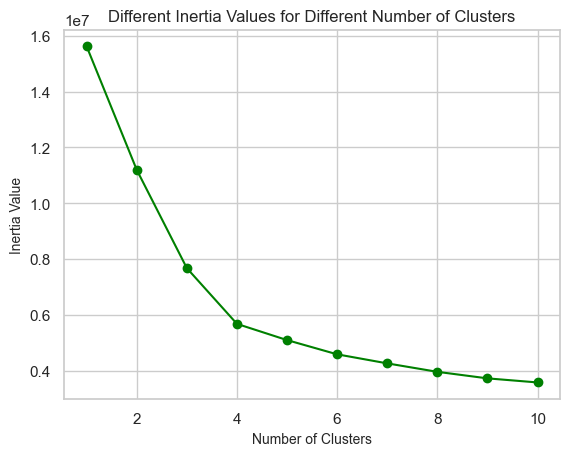

In [362]:
# plot the inertia curve
plt.plot(range(1,11),inertia_list, color='green', marker='o')
plt.scatter(range(1,11),inertia_list)
plt.xlabel("Number of Clusters", size=10)
plt.ylabel("Inertia Value", size=10)
plt.title("Different Inertia Values for Different Number of Clusters", size=12)
plt.show()

In [363]:
## La siguiente librería reafirma la decicion de la seleccion de "codos" efectuada visualmente del grafico anterior
# Seleccion automatica del numero k 
kl_1 = KneeLocator(range(1, 11),
                 inertia_list, curve="convex",
                 direction="decreasing")
kl_1.elbow

4

In [364]:
kmeans_constants = {"init": "random", "n_init": 100, "max_iter": 500, "random_state": 42}

# --- Modelo K-means ---
model_kmeans = KMeans(n_clusters = 4, **kmeans_constants)
model_kmeans.fit(df)

KMeans(init='random', max_iter=500, n_clusters=4, n_init=100, random_state=42)

**Evaluación del algoritmos**

**Calinski Harabasz Score:**

El índice Calinski-Harabasz se basa en la comparación de la relación ponderada entre la suma de los cuadrados (la medida de la separación del clúster) y la suma de los cuadrados dentro del clúster (la medida de cómo se empaquetan estrechamente los puntos dentro de un clúster).

Las soluciones de clúster con valores más grandes del índice corresponden a soluciones "mejores" que las soluciones de clúster con valores más pequeños.

In [365]:
# --- Evaluación del modelo kmeans ---
print(" ### K-MEANS ###")
print('Inertia: ', model_kmeans.inertia_)
print('Silhouette Score: ', silhouette_score(df, model_kmeans.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(df, model_kmeans.labels_))

 ### K-MEANS ###
Inertia:  5685619.534491595
Silhouette Score:  0.33468464049432783
Calinski harabasz score:  4486.82117358425


**Lectura de anterior salida.**
- Se cuenta con una inercia alta
- Un indice de siluetas bajo, entre más cercano a 1 mejor. Este indice informa que tan bien esta echa la agrupación, quíza en este caso el dataset no sea tan suseptible a realizar agrupaciones.
- Indice de referencia de Calinski. Se usa para comparar con otro algoritmo.

In [366]:
## Para obtener la etiqueta que da el algoritmo
# Predicción de los clusters
Cluster_1 = model_kmeans.fit_predict(df)
Cluster_1

array([1, 1, 1, ..., 0, 0, 0])

In [367]:
# Vamos a adjuntar 'Cluster_1' como una nueva variable a 'df':
df_final = df.copy()
df_final['Cluster_1']= Cluster_1

# A partir de ahora, sólo trabajaremos con "df_final"
df_final.head()

,overall,age,height_cm,weight_kg,club_position,pace,shooting,passing,dribbling,defending,physic,defending1,attacking1,skills1,mentality1,movement1,power,Cluster_1
0,93,34,170,72,3,85.0,92.0,91.0,95.0,34.0,65.0,26.333333,85.8,79.000000,73.833333,90.2,77.8,1
1,92,32,185,81,3,78.0,92.0,79.0,86.0,44.0,82.0,32.000000,86.0,68.500000,80.666667,81.6,84.8,1
2,91,36,187,83,3,87.0,94.0,80.0,88.0,34.0,75.0,26.666667,87.6,70.500000,74.333333,85.4,87.2,1
3,91,29,175,68,3,91.0,83.0,86.0,94.0,37.0,63.0,32.000000,80.6,75.166667,77.000000,90.2,71.8,1
4,91,30,181,70,0,76.0,86.0,93.0,88.0,64.0,78.0,62.000000,81.4,74.000000,82.666667,80.0,81.6,3


In [368]:
# NOTA: Se debe asignar una etiqueta a cada categoria de 'Cluster_1' para saber que nos esta informando
# Corroborar las etiquetas que se tiene
df_final.Cluster_1.unique()

array([1, 3, 2, 0])

## **NIVEL DOS**

### **APLICACIÓN DE PCA**

In [417]:
#Cree un dataset reducido que proporcione el 85% de la varianza de entrada que debe explicarse
pca = PCA(n_components=0.75).fit(df)

#Veamos cuántas componentes ha conservado PCA:
pca.n_components_

3

C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\SUSANA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise 

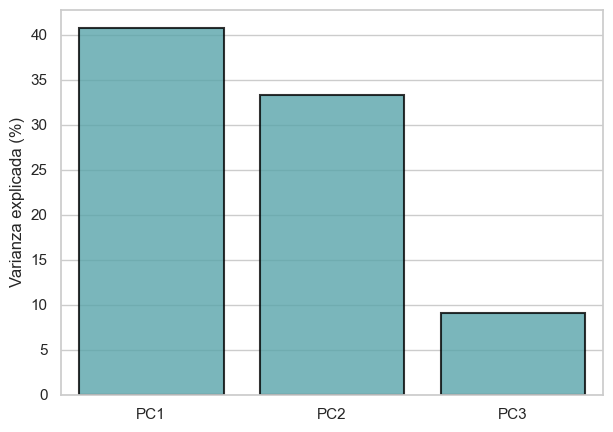

In [418]:
## Diagrama la varianza explicada para cada una de los 5 componentes
## Con este grafico se evalua como las componentes estan explicando las varianzas

# --- Varianza explicada --- 
PCA_variance_1 = pd.DataFrame({'Varianza explicada (%)':
                             pca.explained_variance_ratio_*100})

fig, ax = plt.subplots(1, 1, figsize = (7, 5))

bar = sns.barplot(x = ['PC' + str(i) for i in range(1, 4)],
                  y = PCA_variance_1['Varianza explicada (%)'],
                  linewidth = 1.5, edgecolor = 'k', color = '#4bafb8',
                  alpha = 0.8)

plt.show()

In [420]:
# Porsentaje de varianza explicada por cada componente
PCA_variance_1

,Varianza explicada (%)
0,40.708585
1,33.239932
2,9.044446


**Lectura del anterior gráfico y tabla.** 
- Entre la componente 'PC1' y 'PC2' se esta explicando aproximadamente el 73% de la varianza. 
- Si esta explicando un porsentaje significativo, puesto que para llegar a una varianza explicada del 75% se necesitan de pocas variable (3 en este caso). Este comportamiento se debe a que las variables del dataset son numericas.

In [421]:
#Por último, transforme "df" de 18 columnas X_pca
X_pca_1 = pca.fit_transform(df)
X_pca_1 #Dataset ya transformado

array([[-64.4967349 ,  62.77210121,  10.1022755 ],
       [-58.07015932,  43.41363233,  29.92563333],
       [-57.67298395,  57.1911611 ,  24.56726436],
       ...,
       [ 40.91270041, -10.4546536 , -34.65009861],
       [ 61.94295212, -24.43402669, -20.76835666],
       [ 36.28684315,  -7.73291398,  -6.0809151 ]])

**Interpretación.** No se tiene una lectura tan sencilla de las componentes, pero se puede identificar la influencia de las variables dentro de cada componente, esto es más interpretable en los graficos de los clustering.

### **ALGORITMO K-MEANS**

In [422]:
# Número optimo de K
inertia_list_1 = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=3, n_init=10)
    kmeans.fit(X_pca_1)
    inertia_list_1.append(kmeans.inertia_)

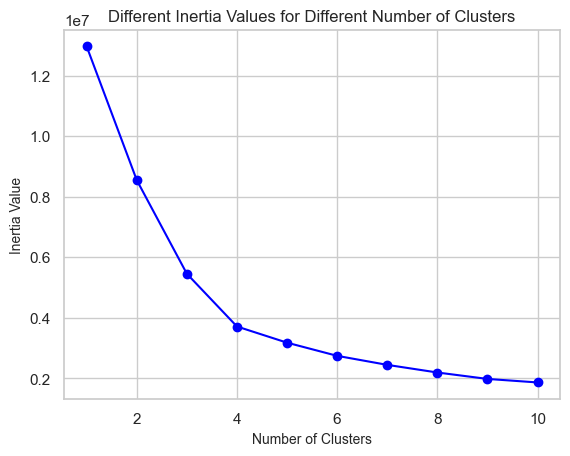

In [423]:
# plot the inertia curve
plt.plot(range(1,11),inertia_list_1, color='blue', marker='o')
plt.scatter(range(1,11),inertia_list_1)
plt.xlabel("Number of Clusters", size=10)
plt.ylabel("Inertia Value", size=10)
plt.title("Different Inertia Values for Different Number of Clusters", size=12)
plt.show()

In [424]:
## La siguiente librería reafirma la decicion de la seleccion de "codos" efectuada visualmente del grafico anterior
# Seleccion automatica del numero k 
kl_1 = KneeLocator(range(1, 11),
                 inertia_list_1, curve="convex",
                 direction="decreasing")
kl_1.elbow

4

In [425]:
kmeans_constants = {"init": "random", "n_init": 100, "max_iter": 500, "random_state": 42}

# --- Modelo K-means ---
model_kmeans = KMeans(n_clusters = 4, **kmeans_constants)
model_kmeans.fit(X_pca_1)

KMeans(init='random', max_iter=500, n_clusters=4, n_init=100, random_state=42)

**Evaluación del algoritmos**

**Calinski Harabasz Score:**

El índice Calinski-Harabasz se basa en la comparación de la relación ponderada entre la suma de los cuadrados (la medida de la separación del clúster) y la suma de los cuadrados dentro del clúster (la medida de cómo se empaquetan estrechamente los puntos dentro de un clúster).

Las soluciones de clúster con valores más grandes del índice corresponden a soluciones "mejores" que las soluciones de clúster con valores más pequeños.

In [426]:
# --- Evaluación del modelo kmeans ---
print(" ### K-MEANS ###")
print('Inertia: ', model_kmeans.inertia_)
print('Silhouette Score: ', silhouette_score(X_pca_1, model_kmeans.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(X_pca_1, model_kmeans.labels_))

 ### K-MEANS ###
Inertia:  3711768.793213379
Silhouette Score:  0.4001805412222673
Calinski harabasz score:  6400.861022743991


**Lectura de anterior salida.**
- Se cuenta con una inercia alta
- Un indice de siluetas bajo, entre más cercano a 1 mejor. Este indice informa que tan bien esta echa la agrupación, quíza en este caso el dataset no sea tan suseptible a realizar agrupaciones.
- Indice de referencia de Calinski. Se usa para comparar con otro algoritmo.

**CONCLUSIÓN HASTA EL MOMENTO** 

El algoritmo de kmeans si esta haciendo una buena agrupación, esto se debe quiza a la información del dataset

In [427]:
## Para obtener la etiqueta que da el algoritmo
# Predicción de los clusters
Cluster_2 = model_kmeans.fit_predict(df)
Cluster_2

array([1, 1, 1, ..., 0, 0, 0])

In [428]:
# Vamos a adjuntar 'Cluster_2' como una nueva variable a 'df':

df_final['Cluster_2'] = Cluster_2

# A partir de ahora, sólo trabajaremos con "df_final"
df_final.head()

,overall,age,height_cm,weight_kg,club_position,pace,shooting,passing,dribbling,defending,physic,defending1,attacking1,skills1,mentality1,movement1,power,Cluster_1,Cluster_2,Cluster_3
0,93,34,170,72,3,85.0,92.0,91.0,95.0,34.0,65.0,26.333333,85.8,79.000000,73.833333,90.2,77.8,1,1,2
1,92,32,185,81,3,78.0,92.0,79.0,86.0,44.0,82.0,32.000000,86.0,68.500000,80.666667,81.6,84.8,1,1,2
2,91,36,187,83,3,87.0,94.0,80.0,88.0,34.0,75.0,26.666667,87.6,70.500000,74.333333,85.4,87.2,1,1,2
3,91,29,175,68,3,91.0,83.0,86.0,94.0,37.0,63.0,32.000000,80.6,75.166667,77.000000,90.2,71.8,1,1,2
4,91,30,181,70,0,76.0,86.0,93.0,88.0,64.0,78.0,62.000000,81.4,74.000000,82.666667,80.0,81.6,3,3,0


In [429]:
# NOTA: Se debe asignar una etiqueta a cada categoria de 'Cluster_2' para saber que nos esta informando
# Corroborar las etiquetas que se tiene
df_final.Cluster_2.unique()

array([1, 3, 2, 0])

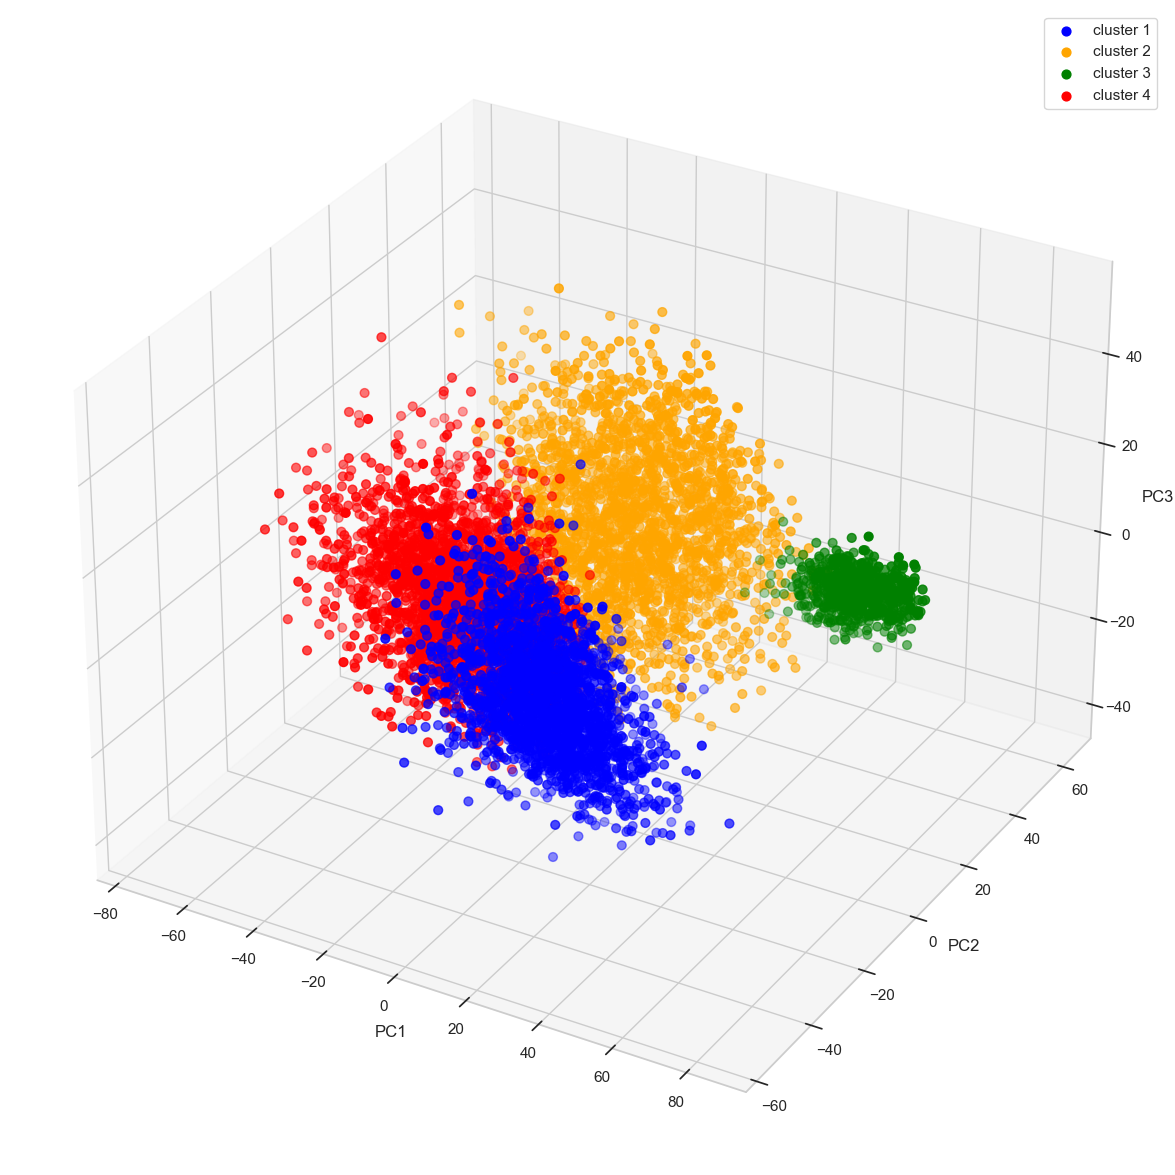

In [431]:
### Gráfico de dispersión respecto al 'cluster_2'
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_1[Cluster_2 == 0,0],X_pca_1[Cluster_2 == 0,1],X_pca_1[Cluster_2 == 0,2], s = 40 , color = 'blue', label = "cluster 1")
ax.scatter(X_pca_1[Cluster_2 == 1,0],X_pca_1[Cluster_2 == 1,1],X_pca_1[Cluster_2 == 1,2], s = 40 , color = 'orange', label = "cluster 2")
ax.scatter(X_pca_1[Cluster_2 == 2,0],X_pca_1[Cluster_2 == 2,1],X_pca_1[Cluster_2 == 2,2], s = 40 , color = 'green', label = "cluster 3")
ax.scatter(X_pca_1[Cluster_2 == 3,0],X_pca_1[Cluster_2 == 3,1],X_pca_1[Cluster_2 == 3,2], s = 40 , color = 'red', label = "cluster 4")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()

## **NIVEL TRES**

### **ALGORITMO GaussianMixture**

Text(0.5, 0, 'Número de Clusters')

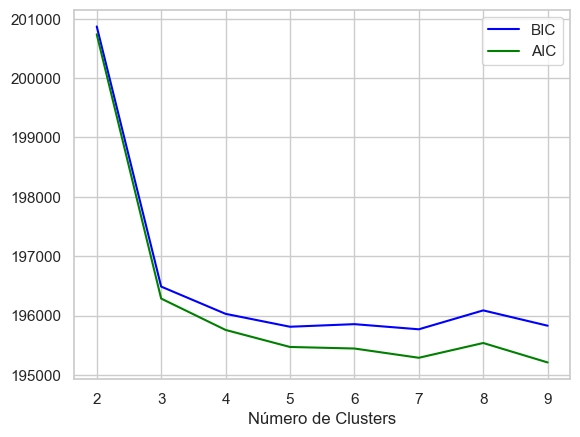

In [433]:
# --- Estimación de hiperparámetros ---

n_components = np.arange(2, 10)

models_g = [GaussianMixture(n_components=n, random_state=123).fit(X_pca_1) for n in n_components]

plt.plot(n_components, [m.bic(X_pca_1) for m in models_g], label="BIC", color="blue")
plt.plot(n_components, [m.aic(X_pca_1) for m in models_g], label="AIC", color="green")
plt.legend()
plt.xlabel("Número de Clusters")

In [434]:
# --- Modelo GMM ---
model_gmm = GaussianMixture(n_components=3, random_state=123, covariance_type = 'full').fit(X_pca_1)

In [435]:

# --- Evaluación del modelo GMM ---
labels_ = model_gmm.predict(X_pca_1)

print(" ### GaussianMixture ###")
print('Silhouette Score: ', silhouette_score(X_pca_1, labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(X_pca_1, labels_))

 ### GaussianMixture ###
Silhouette Score:  0.41967990882110734
Calinski harabasz score:  5160.70272029566


In [436]:
# Predicción de los clusters
Cluster_3 = model_gmm.fit_predict(X_pca_1)

df_final['Cluster_3']= Cluster_3

# A partir de ahora, sólo trabajaremos con "df_final"
df_final.head(3)

,overall,age,height_cm,weight_kg,club_position,pace,shooting,passing,dribbling,defending,physic,defending1,attacking1,skills1,mentality1,movement1,power,Cluster_1,Cluster_2,Cluster_3
0,93,34,170,72,3,85.0,92.0,91.0,95.0,34.0,65.0,26.333333,85.8,79.0,73.833333,90.2,77.8,1,1,2
1,92,32,185,81,3,78.0,92.0,79.0,86.0,44.0,82.0,32.000000,86.0,68.5,80.666667,81.6,84.8,1,1,2
2,91,36,187,83,3,87.0,94.0,80.0,88.0,34.0,75.0,26.666667,87.6,70.5,74.333333,85.4,87.2,1,1,2


In [437]:
df_final['Cluster_3'].value_counts()

Cluster_3
0    4731
2    2280
1     700
Name: count, dtype: int64

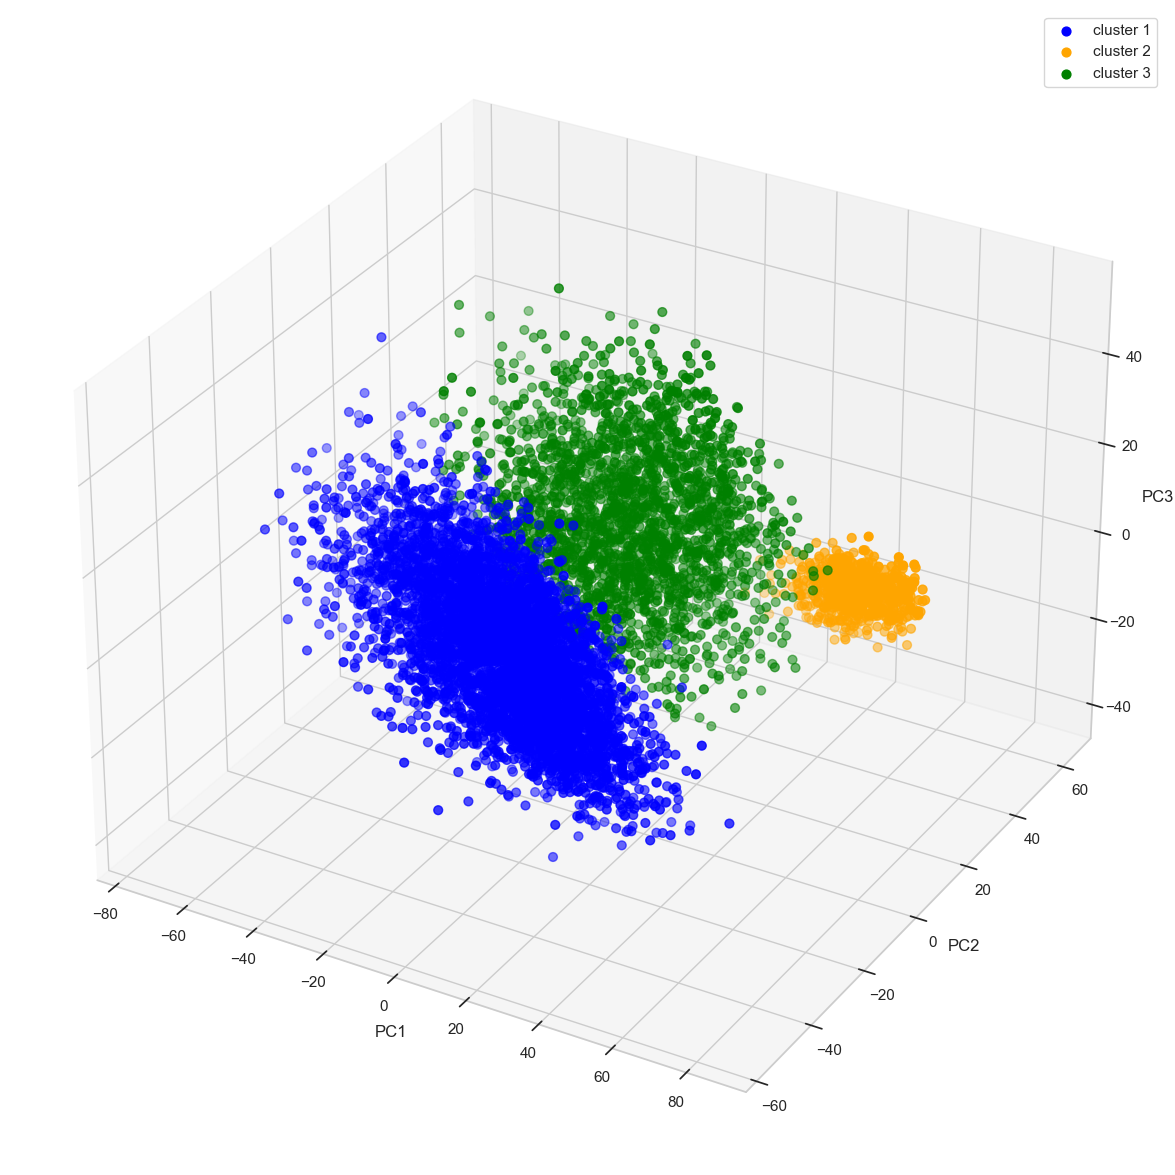

In [438]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_1[Cluster_3 == 0,0],X_pca_1[Cluster_3 == 0,1],X_pca_1[Cluster_3 == 0,2], s = 40 , color = 'blue', label = "cluster 1")
ax.scatter(X_pca_1[Cluster_3 == 1,0],X_pca_1[Cluster_3 == 1,1],X_pca_1[Cluster_3 == 1,2], s = 40 , color = 'orange', label = "cluster 2")
ax.scatter(X_pca_1[Cluster_3 == 2,0],X_pca_1[Cluster_3 == 2,1],X_pca_1[Cluster_3 == 2,2], s = 40 , color = 'green', label = "cluster 3")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()